# The problem: Generative AI recreating football game

First we do some import and we load the data

In [3]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import random

file_match1 = "match_1.json"
file_match2 = "match_2.json"

df_match1 = pd.read_json(file_match1)
df_match2 = pd.read_json(file_match2)

actions_type = ["dribble", "tackle", "no action", "shot", "pass", "cross", "run", "walk", "rest"]

print(df_match1.head())
print(df_match2.head())

  label                                               norm
0  walk  [23.177037336396975, 23.361525285249378, 21.53...
1  walk  [20.998214383911275, 19.182798059840767, 18.27...
2  walk  [21.95259682019565, 20.62720484424047, 22.5554...
3  walk  [19.39209748358647, 19.30460665293087, 18.9787...
4  rest  [22.069263037713093, 19.672270483203395, 19.88...
       label                                               norm
0  no action  [104.42423889328715, 87.63989343949717, 128.52...
1        run  [108.03112639951678, 92.57566083451651, 81.303...
2       pass  [17.837163554142162, 39.435455203974186, 51.64...
3       rest  [21.91843920469922, 18.11914155706377, 21.7137...
4       walk  [20.86063916182152, 17.8097748446304, 14.35537...


## 1) Make a simple exploration data analysis of the input data. Can you find some differences between some different actions?


In [7]:
# In a first time, we want to compare the mean and the standard deviation
# for each type of action

def get_mean_std_norm(df):
  """
  Get a dataframe and print the mean and
  standard deviation for each type of action
  df: DataFrame containing information of the match
  """
  # We create 2 dictionnaries, one for the mean
  # and one for the standard deviation
  mean_norm_dict = {}
  std_norm_dict = {}

  for index, row in df.iterrows():
      action = row['label']
      norm_data = row['norm']

      # We retrieve the norm associated with
      # an action and calculate the two values
      mean_norm = sum(norm_data) / len(norm_data)
      std_norm = np.std(norm_data)

      if action not in mean_norm_dict:
          mean_norm_dict[action] = []
          std_norm_dict[action] = []
      # We add theses values to our dictionnaries
      mean_norm_dict[action].append(mean_norm)
      std_norm_dict[action].append(std_norm)

  # We sort our two dictionnaries for a better reading
  mean_norm_dict_sorted = dict(sorted(mean_norm_dict.items()))
  std_norm_dict_sorted = dict(sorted(std_norm_dict.items()))

  # We display the information
  for action in mean_norm_dict_sorted:
      print(f"Action: {action}, mean acceleration norm: {sum(mean_norm_dict_sorted[action]) / len(mean_norm_dict_sorted[action])}")
      print(f"Action: {action}, mean standard deviation of acceleration norm: {sum(std_norm_dict_sorted[action]) / len(std_norm_dict_sorted[action])}")
  print("\n")

get_mean_std_norm(df_match1)
get_mean_std_norm(df_match2)

Action: cross, mean acceleration norm: 46.708457756829354
Action: cross, mean standard deviation of acceleration norm: 48.14174920527277
Action: dribble, mean acceleration norm: 52.88252588755937
Action: dribble, mean standard deviation of acceleration norm: 36.16286571552572
Action: pass, mean acceleration norm: 64.13327808012248
Action: pass, mean standard deviation of acceleration norm: 51.04175260199318
Action: rest, mean acceleration norm: 21.833566842904276
Action: rest, mean standard deviation of acceleration norm: 3.7825203221286228
Action: run, mean acceleration norm: 54.40459298904968
Action: run, mean standard deviation of acceleration norm: 37.846293222907306
Action: shot, mean acceleration norm: 113.27871688343298
Action: shot, mean standard deviation of acceleration norm: 91.3472155090433
Action: tackle, mean acceleration norm: 70.66858172485196
Action: tackle, mean standard deviation of acceleration norm: 73.2278531985968
Action: walk, mean acceleration norm: 28.09486687

It can be seen that the standard deviation and the mean are quite different depending on the action (for exemple 3 for the rest and 11 for the walk in the first dataframe).
We can try to display a smooth distribution for a selected action to have a better visualization of the data.

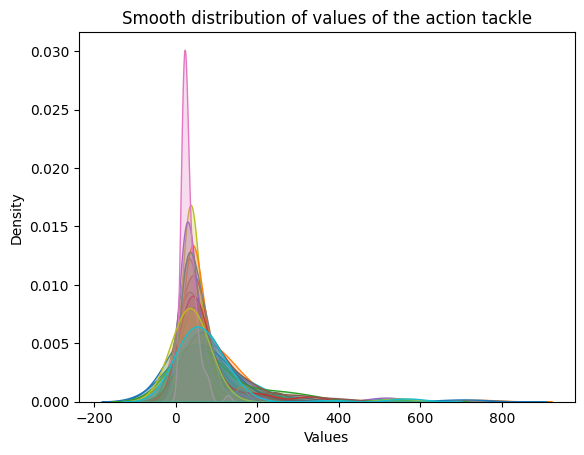

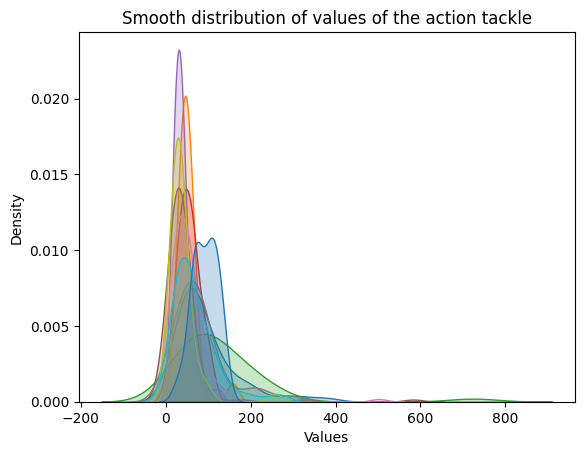

In [16]:
def smooth_distribution_graph(df, action):
  """
  Take a Dataframe and an action and display a smooth distribution
  according to the values of the acceleration norm
  df: dataframe containing information about the match
  action: the selected action
  """
  data = df[df["label"] == action]["norm"].tolist()
  for gait in data:
    sns.kdeplot(gait, fill=True)

  plt.title(f'Smooth distribution of values of the action {action}')
  plt.xlabel('Values')
  plt.ylabel('Density')
  plt.show()

smooth_distribution_graph(df_match1, "tackle")
smooth_distribution_graph(df_match2, "tackle")

We therefore have a Gausian distribution of the values associated with an action. It might be interesting to compare all the actions to see the differences.

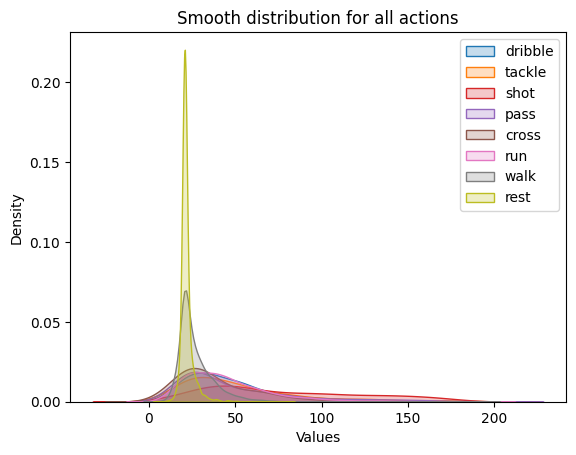

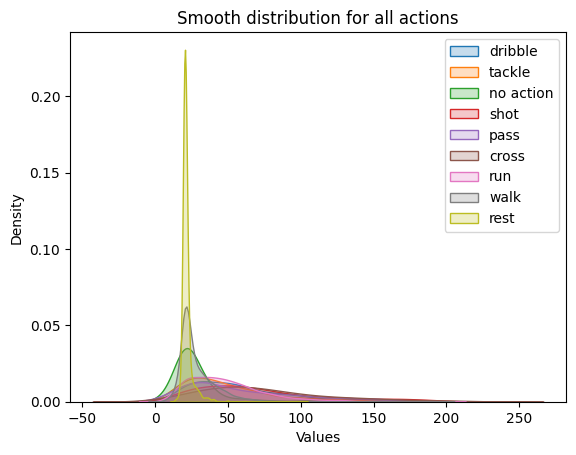

In [11]:
def get_all_graph(df):
  """
  Get all the graph for all the type of action
  df: dataframe containing information about the match
  """
  dict_action = {}
  for action in actions_type:
    # get a list of list of all the acceleration norm according to an action,
    # transform the list into a 1dim list and remove all the values > 200
    # (for a better reading of the graph)
    data = df[df["label"] == action]["norm"].tolist()
    dict_action[action] = [elt for tmp in data for elt in tmp if elt < 200]

  for action in dict_action:
    sns.kdeplot(dict_action[action], fill=True, label=action)
  plt.legend()
  plt.title('Smooth distribution for all actions')
  plt.xlabel('Values')
  plt.ylabel('Density')
  plt.show()

get_all_graph(df_match1)
get_all_graph(df_match2)

We can therefore see that the rest, walk and no action actions have a close distribution with high densities, unlike the other actions which have more varied standard acceleration values.
This result is due to norm values which tend to increase with the intensity of the action (run or shot is more intense than walk, for example). Note that we have maxed out the values to be displayed at 200, but some values can go beyond 500.

## 2) List of different approaches of how such game can be re-created. You can also use consider the other type of the data than we are providing.

It is possible to recreate a match with the available data in several ways

1. The most logical way would be to use a machine learning algorithm that learns lists of norms based on a given action. We would then need to use another algorithm that would create the match of 0 (i.e. find a logic in the path of actions). Once the action sequence had been created, we could then use our model to create reliable acceleration norms.
2. Another method would be to use the statistics we calculated in part 1 of the exercise. Now that we know that norms follow a Gausian distribution, we could use the mean and standard deviation values to model distributions according to a given action. We'd then just have to develop an algorithm to determine a plausible sequence of actions (as in point 1).
3. Using other types of data, I think it's possible to use video analysis of a match to determine the type of action at any given moment. The algorithm would be much more complex and would contain numerous complications, but it's totally possible with today's technologies.


## 3) Use the attached data for recreating the game. We expect the same format of theoutput as input. More precisely, we expect that the recreated game will be anested list of dictionaries, where each dictionary will include two keys: norm and label. Some hints:
- The sequence of labels should make sense, e.g. sequence of actions
{shot, shot, shot, shot, shot} could be suspicious
- Always check the gait length, e.g. be aware if the gait is not too short
or too long (e.g 0.1 s of gait would be too short, and gait of length 3s
would be also too long)


## 4) Please fully describe at least one approach you would choose (in jupyter notebook or some additional pdf):
- The chosen architecture/algorithm. Why the decision was made, why it
makes sense, and what kind of input it assumes. If the mathematical theory
for the chosen approach is too complicated, the flow chart is enough.
- The pre- / post-processing of the data

The best solution would be to use a generative model (such as LSTM) that takes a label (in our case, an action) as input and returns a list of acceleration norm. We'd need to enlarge our training data to get more relevant results.
Then we'd need to pre-process the data: check the sequence of actions, shorten certain norm lists or divide them into two or even three (the maximum quantity in a single list should be 150 values, which corresponds to a 3-second action).

It would also be possible to use a model that would generate a list of actions based on the lists we have (finding a logical link in each action sequence).
It could be interesting to divide our action list into several sub-lists to broaden our training data.

For the rest of the exercise, we decided to use the information gathered in the first part to try and answer the problem. Since the norms follow a Gaussian distribution, we can use the mean and standard deviation to recreate values. 